In [62]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, mkdir
from os.path import isfile, join, exists
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
def gauss_compress_step(img):
    return cv.GaussianBlur(img, (5,5), 0)[::2, ::2, :].clip(0, 255).astype(np.uint8)

In [3]:
def compress_image(img):
    return gauss_compress_step(gauss_compress_step(img))

In [4]:
def show_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [5]:
def compress_all_jpg_in_directory(path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    result_path = path + "_compress"
    if not exists(result_path):
        mkdir(result_path)
        
    for num, filename in enumerate(onlyfiles):
        img = cv.imread(path + "/" + filename)
        name = "pict_" + str(num) + ".png"
        compress_img = compress_image(img)
        cv.imwrite(result_path + "/" + name, compress_img)   

In [6]:
def draw_matches(img_first, img_second, callable_descriptor):
    keypoints_first, descriptors_first = callable_descriptor(img_first)
    keypoints_second, descriptors_second = callable_descriptor(img_second)
    draw_matches_tech(img_first, keypoints_first, descriptors_first,
                      img_second, keypoints_second, descriptors_second)

In [7]:
def draw_matches_tech(img_first, keypoints_first, descriptor_first, 
                 img_second, keypoints_second, descriptor_second):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

    matches = bf.match(descriptor_first, descriptor_second)
    matches = sorted(matches, key = lambda x:x.distance)    
    img3 = cv.drawMatches(img_first, keypoints_first, img_second, keypoints_second, matches[:], img_second, flags=2)
    plt.imshow(img3)
    plt.show()

In [8]:
def match_accuracy(matches, count_all_features):
    first_set_idx = [matches[i].trainIdx for i in range(len(matches))]
    second_set_idx = [matches[i].queryIdx for i in range(len(matches))]
    first_set_count_features = len(set(first_set_idx))
    second_set_count_features = len(set(second_set_idx))
    
    return (first_set_count_features + second_set_count_features) / count_all_features    

In [9]:
def match_mean_distance(matches):
    return np.mean([matches[i].distance for i in range(len(matches))])

In [10]:
def calc_SIFT(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [11]:
def calc_AKAZE(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.AKAZE_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [12]:
def calc_BRISK(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.BRISK_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [13]:
def calc_process_images(origin_image, list_of_images, callback_descriptor, descriptor_name):
    origin_keypoints, origin_descriptors = callback_descriptor(origin_image)
    result_metrics = []
    if descriptor_name in ['SIFT', 'AKAZE']:
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    elif descriptor_name == 'BRISK':
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    for current_image in list_of_images:
        start_time = time.time()
        
        current_keypoints, current_descriptors = callback_descriptor(current_image[0])
        matches = bf.match(origin_descriptors, current_descriptors)
        
        curr_time = time.time() - start_time
        
        accury = match_accuracy(matches, len(origin_keypoints) + len(current_keypoints))
        mean_distance = match_mean_distance(matches)
        result_metrics.append((accury, mean_distance, curr_time, current_image[0]))
    
    return result_metrics

In [14]:
def prepare_data(path, need_compress=False):
    if need_compress:
        compress_all_jpg_in_directory(path)
        path = path + "_compress"
        
    
    list_of_images = []
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for im in images:
        current_image = cv.imread(path + "/" + im)
        list_of_images.append(current_image)
    
    return list_of_images

In [15]:
def main_process(descriptor_name, path_to_folder_with_images, path_to_origin_image, need_to_compress):
    #ну тут нужно харкодить))
    name_to_desc = {'SIFT': calc_SIFT, 'AKAZE': calc_AKAZE, 'BRISK': calc_BRISK}
    origin_image = cv.imread(path_to_origin_image)
    
    return calc_process_images(origin_image, prepare_data(path_to_folder_with_images, need_to_compress),
                               name_to_desc[descriptor_name], descriptor_name)

In [16]:
def draw_results(metrics_result, descriptor_name, origin_image):
    n = len(metrics_result)
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    y = [metrics_result[i][0] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('match accuracy')
    plt.xlabel('number of sample')
    plt.ylabel('accuracy')
    
    plt.subplot(1, 3, 2)
    y = [metrics_result[i][1] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('mean distance')
    plt.xlabel('number of sample')
    plt.ylabel('distance')
    
    plt.subplot(1, 3, 3)
    y = [metrics_result[i][2] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('time')
    plt.xlabel('number of sample')
    plt.ylabel('time')
    
    plt.show()

Будем обучать наш классификатор уже на привычном нам объекте:

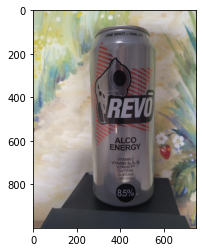

In [192]:
show_image(cv.imread('dataset1/original_picture.png'))

Для начала соберем наш датасет, который будет состоять из фотографий с тремя видами предметов. 
Мы зададимся себе целью классифицировать наш предмет на фотографии, либо его отсутствие -- то есть мы имеем дело
с бинарной классификаций.


Фотографии с нашим объектом:

In [193]:
picture_with_object = prepare_data('dataset1/dataset1_compress', False)

print('Count picture with object:', len(picture_with_object))

Count picture with object: 108


Фотографии без нашего объекта:

In [194]:
picture_without_object = prepare_data('dataset2/dataset2_compress', False)
picture_without_object.extend(prepare_data('dataset3/dataset3_compress', False))

print('Count picture without object', len(picture_without_object))

Count picture without object 210


Теперь соберем общий датасет 

In [195]:
data = picture_with_object + picture_without_object
y = np.hstack([np.ones(len(picture_with_object)), np.zeros(len(picture_without_object))])

Разобьем на train и test (test - 25%). Заметим, что данные у нас упорядоченные, но train_test_split делает случайное разделение выборки.

In [196]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

Как видим выборка успешно перемешалась:

In [197]:
print(y_train[0:20])

[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Далее что бы работать с классификацией, нам необходимо преобразование, которые делает из картинки вектор. Для этого воспользуем методом bag of words, который будет работать с произвольным дескриптором.


Кратко опишем метод bag of words. У нас имеется train выборка, посчитаем для каждого изображения выбранный
дескриптор, получим некий набор дескрипторов для данного изображение. Собираем все дескрипторные описания каждого
изображение вместе, применяем K-means, и получаем k-центров кластеров. И далее, чтобы получить **k-мерное представления**
изображения строим нормированную диаграмму принадлежности каждого дескрипторного описания к некому кластеру.

In [198]:
def fit_bag_of_words(data, callable_descriptor):
    all_descriptors = []
    for idx, current_image in enumerate(data):
        keypoints, descriptors = callable_descriptor(current_image)
        all_descriptors.extend(descriptors)
    
    # count of clusters
    k = 50
    kmeans = KMeans(n_clusters=k, verbose=False).fit(all_descriptors)
    
    return kmeans

Обучим bag of words на train выборке используя дескриптор SIFT

In [199]:
k_means_train_sift = fit_bag_of_words(x_train, calc_SIFT)

Теперь чтобы уметь получать векторное k-мерное представление картинки, научимся считать нормированные диаграммы по уже обучененому K-means

In [200]:
def picture_to_vector(picture, k_means_pretrained, callable_descriptor, k_cluster=50):
    keypoints, descriptors = callable_descriptor(picture)
    histogram = np.zeros(k_cluster)
    kp_count = len(keypoints)
    
    for d in descriptors:
        idx = k_means_pretrained.predict([d])
        histogram[idx] += 1.0 / kp_count
        
    return histogram
    

Отлично, теперь мы умеем находить представление картинки в k-мерном пространстве в зависимости от дескриптора.

Теперь сформируем датасеты в векторном представлении картинок, и проведем эксперименты с классификаторами Quadratic classifier и Gaussian Process Classifier. Используем дескриптор SIFT

In [201]:
x_train_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_train])
x_test_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_test])

Теперь обучим классификаторы Quadratic classifier, Gaussian Process Classifier и Support Vector Classifier

In [202]:
quadratic_clf = QuadraticDiscriminantAnalysis()
gaussian_process_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
svc_clf = SVC(kernel="linear", C=0.025)

quadratic_clf.fit(x_train_vec_sift, y_train)
gaussian_process_clf.fit(x_train_vec_sift, y_train)
svc_clf.fit(x_train_vec_sift, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Теперь напишем функцию, которая делает предсказания на тестовой выборке, и считает accuracy, false-positive,
false-negative и время обработки тестового датасета.

In [41]:
def false_positive(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 1 and y_true[i] == 0:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [42]:
def false_negative(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 0 and y_true[i] == 1:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [43]:
class PredictResult:
    def __init__(self, accuracy, mean_time, false_negative_score, false_positive_score):
        self.accuracy = accuracy
        self.mean_time = mean_time
        self.false_negative_score = false_negative_score
        self.false_positive_score = false_positive_score
        
    def print_result(self):
        print('Accuracy =', self.accuracy)
        print('Mean time =', self.mean_time)
        print('False negative score =', self.false_negative_score)
        print('False positive score =', self.false_positive_score)

In [44]:
def predict_probability(pretrained_clf, x_test, y_true):
    start_time = time.time()
    #y_predict_proba = pretrained_clf.predict_proba(x_test_vec_sift)
    y_predict = pretrained_clf.predict(x_test)
    end_time = time.time() - start_time
    accuracy = accuracy_score(y_true, y_predict)
    mean_time = end_time / x_test.shape[0]
    false_negative_score = false_negative(y_true, y_predict)[0]
    false_positive_score = false_positive(y_true, y_predict)[0]
    
    return y_predict, PredictResult(accuracy, mean_time, false_negative_score, false_positive_score)

Теперь сделаем предсказания с помощью наших классификаторов и посмотрим на результаты:

In [45]:
quadratic_clf_pred, quadratic_result = predict_probability(quadratic_clf, x_test_vec_sift, y_test)
gaussian_process_clf_pred, gaussian_process_result = predict_probability(gaussian_process_clf, x_test_vec_sift, y_test)
svc_clf_pred, svc_result = predict_probability(svc_clf, x_test_vec_sift, y_test)

Посмотрим на результаты работы Quadratic classifier

In [46]:
quadratic_result.print_result()

Accuracy = 0.95
Mean time = 1.7309188842773436e-05
False negative score = 4
False positive score = 0


Так же посмотрим на confusion matrix:

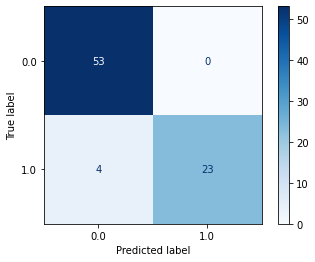

In [60]:
plot_confusion_matrix(quadratic_clf, x_test_vec_sift, y_test, cmap=plt.cm.Blues);

Мы получили хорошую точность класификации, а учитывая, что у нас достаточно сбалансированые классы (банок ревок около трети всего датасета),
можно считать это надежным показателем качества модели. Также среднее время обработки одной картинки очень мало, что позволит обрабатывать большие объемы данных, но стоит заметить, что значительные вычислительные ресурсы трятатся на этапе получения векторного представления картинки. И мы получили 4 false negative результата, посмотрим на них.

In [47]:
false_negative_idx = false_negative(y_test, quadratic_clf_pred)[1]

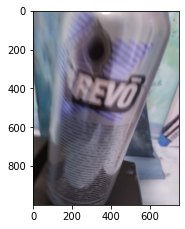

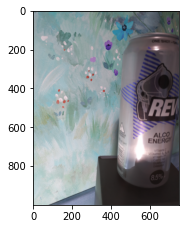

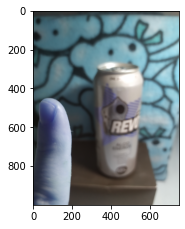

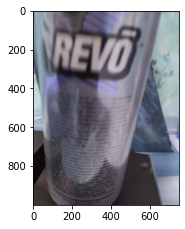

In [48]:
for i in range(len(false_negative_idx)):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_test[false_negative_idx[i]])

Как видим на этих картинках наш классификатор идентифицирует ложное отсутствие предмета. Зато мы не имеем ни одного ложно положительного срабатывания.

Посмотрим на результаты работы Gaussian Process Classifier

In [49]:
gaussian_process_result.print_result()

Accuracy = 0.9875
Mean time = 3.299415111541748e-05
False negative score = 1
False positive score = 0


Посмотри на confusion matrix:

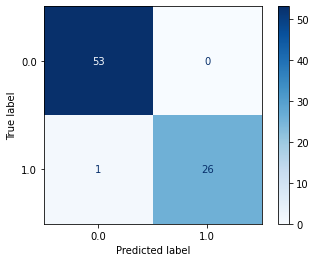

In [65]:
plot_confusion_matrix(gaussian_process_clf, x_test_vec_sift, y_test, cmap=plt.cm.Blues);

Как видим, мы имеем так же достаточно хорошее качество, и сравнительно маленькое время обработки изображения. Мы получили 0 ложно положительных срабатываний и 1 ложно отрицательное.

Ложно отрицательное срабатывание:

In [50]:
false_negative_idx = false_negative(y_test, gaussian_process_clf_pred)[1]

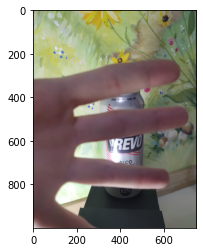

In [51]:
show_image(x_test[false_negative_idx[0]])

И посмотрим на результаты Supper Vector Classifier

In [52]:
svc_result.print_result()

Accuracy = 0.6625
Mean time = 2.0810961723327635e-05
False negative score = 27
False positive score = 0


Confusion matrix:

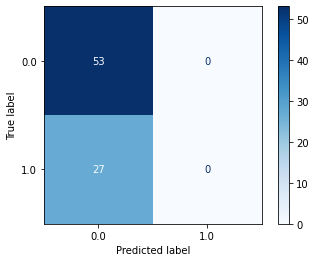

In [66]:
plot_confusion_matrix(svc_clf, x_test_vec_sift, y_test, cmap=plt.cm.Blues);

Как видим, SVC справился намного хуже, чем классификаторы Quadratic classifier и Gaussian Process Classifier. Стоить заметить, что мы получили ни одного ложно позитивного срабатывания, что говорит о том, что наш классификатор часто ошибается на предметах, которые являются представителями нужного класса, но классификатор таковыми их не считает. Скорее всего это обусловнено структурой пространста, и алгоритма связанным с гуссовскими распределения удалось более успешно восстановить зависимость.

Посмотрим на несколько false-negative результатов:

In [67]:
false_negative_idx = false_negative(y_test, svc_clf_pred)[1]

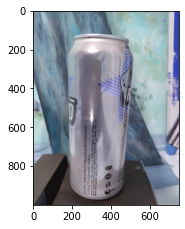

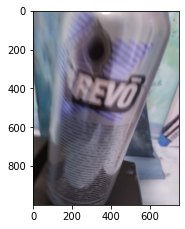

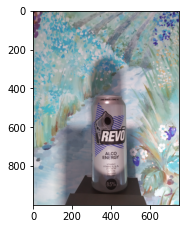

In [68]:
for i in range(3):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_test[false_negative_idx[i]])

Там, где мы без проблем узнаем старую любимую банку рево, наш алгоритм SVC ошибается...

Можно сделать вывод, что для успешной классификации необходим рациональный подход к выбору и обучению классификатора. Что мы успешно и продемонстрировали в работе.

Теперь аналогичные шаги, с переводом в векторное пространство (для истинности результатов как и в предыдущем эксперименте - 50 мерное) и последующим обучением классификаторов проведем с вторым датасетом.

Посмотрим на типичного представителя второго датасета:

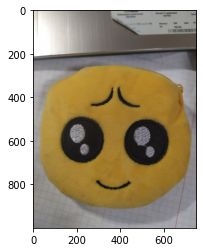

In [69]:
show_image(cv.imread('dataset2/original_picture.png'))

Фотографии с нашим объектом:

In [72]:
picture_with_object = prepare_data('dataset2/dataset2_compress', False)
print('Count picture with object:', len(picture_with_object))

Count picture with object: 95


Фотографии без нашего объекта:

In [74]:
picture_without_object = prepare_data('dataset1/dataset1_compress', False)
picture_without_object.extend(prepare_data('dataset3/dataset3_compress', False))

print('Count picture without object', len(picture_without_object))

Count picture without object 223


Собираем общий датасет (картинки с нашим объектом + картинки без нашего объекта)

In [76]:
data = picture_with_object + picture_without_object
y = np.hstack([np.ones(len(picture_with_object)), np.zeros(len(picture_without_object))])

Разбиваем на test и train

In [77]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

Теперь обучаем bag of words на train выборке для нашего датасета (используем дескриптор SIFT)

In [78]:
k_means_train_dataset_two = fit_bag_of_words(x_train, calc_SIFT)

Теперь сформируем датасеты в векторном представлении картинок, и проведем эксперименты с классификаторами Quadratic classifier и Gaussian Process Classifier. Используем дескриптор SIFT

In [79]:
x_train_vec_dataset_two = np.array([picture_to_vector(pic, k_means_train_dataset_two, calc_SIFT) 
                                    for pic in x_train])
x_test_vec_dataset_two = np.array([picture_to_vector(pic, k_means_train_dataset_two, calc_SIFT) 
                                   for pic in x_test])

Теперь обучим классификаторы Quadratic classifier, Gaussian Process Classifier и Support Vector Classifier

In [86]:
quadratic_clf_dataset_two = QuadraticDiscriminantAnalysis()
gaussian_process_clf_dataset_two = GaussianProcessClassifier(1.0 * RBF(1.0))
svc_clf_dataset_two = SVC(kernel="linear", C=0.025)

quadratic_clf_dataset_two.fit(x_train_vec_dataset_two, y_train)
gaussian_process_clf_dataset_two.fit(x_train_vec_dataset_two, y_train)
svc_clf_dataset_two.fit(x_train_vec_dataset_two, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Теперь сделаем предсказания с помощью наших классификаторов и посмотрим на результаты:

In [87]:
quadratic_clf_pred_dataset_two, quadratic_result_dataset_two = predict_probability(quadratic_clf_dataset_two, x_test_vec_dataset_two, y_test)
gaussian_process_clf_pred_dataset_two, gaussian_process_result_dataset_two = predict_probability(gaussian_process_clf_dataset_two, x_test_vec_dataset_two, y_test)
svc_clf_pred_dataset_two, svc_result_dataset_two = predict_probability(svc_clf_dataset_two, x_test_vec_dataset_two, y_test)

Посмотрим на результаты работы Quadratic classifier

In [90]:
quadratic_result_dataset_two.print_result()

Accuracy = 0.975
Mean time = 2.397000789642334e-05
False negative score = 1
False positive score = 1


Confusion matrix:

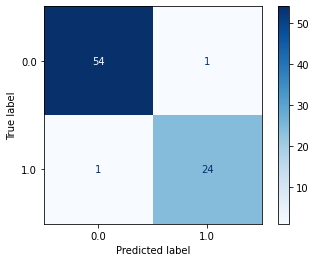

In [94]:
plot_confusion_matrix(quadratic_clf_dataset_two, x_test_vec_dataset_two, y_test, cmap=plt.cm.Blues);

Как видим, с помощью Quadratic classifier мы второй раз получаем достаточно хорошие результаты, и в силу сбалансированности датасетов - accuracy является достаточно правдивой метрикой качества. Мы получили 1 ложно позитивное и 1 ложно негативное срабатывание, посмотрим на каких объектах ошибается наш классификатор.

Ложно позитивное срабатывание:

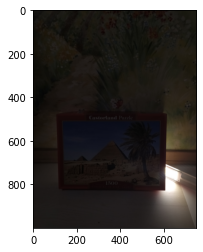

In [114]:
false_positive_idx = false_positive(y_test, quadratic_clf_pred_dataset_two)[1]
show_image(x_test[false_positive_idx[0]]);

Ложно негативное срабатывание:

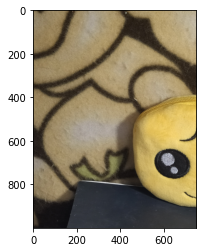

In [115]:
false_negative_idx = false_negative(y_test, quadratic_clf_pred_dataset_two)[1]
show_image(x_test[false_negative_idx[0]]);

Посмотрим на результаты работы Gaussian Process Classifier

In [116]:
gaussian_process_result_dataset_two.print_result()

Accuracy = 0.95
Mean time = 3.953278064727783e-05
False negative score = 3
False positive score = 1


Confusion matrix:

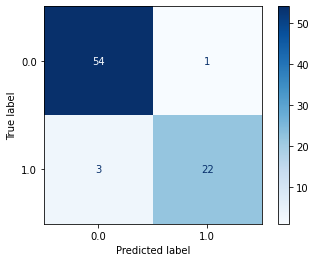

In [117]:
plot_confusion_matrix(gaussian_process_clf_dataset_two, x_test_vec_dataset_two, y_test, cmap=plt.cm.Blues);

Как видим, мы Gaussian process classifier опять же позволяет нам достичь высокого качества классификация, мы получаем всего 3 ложного негативных результата и 1 ложно позитивный. Посмотрим на них.

Ложно позитивное срабатывание:

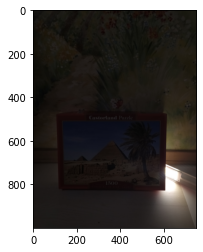

In [118]:
false_positive_idx = false_positive(y_test, gaussian_process_clf_pred_dataset_two)[1]
show_image(x_test[false_positive_idx[0]]);

Ложно негативное срабатывание:

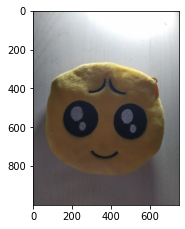

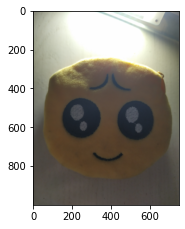

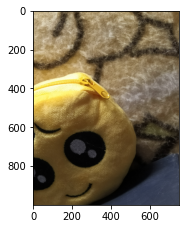

In [121]:
false_negative_idx = false_negative(y_test, gaussian_process_clf_pred_dataset_two)[1]
for i in range(len(false_negative_idx)):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    show_image(x_test[false_negative_idx[i]])

Посмотрим на результаты классификатора SVC

In [109]:
svc_result_dataset_two.print_result()

Accuracy = 0.6875
Mean time = 2.1478533744812013e-05
False negative score = 25
False positive score = 0


Confusion matrix

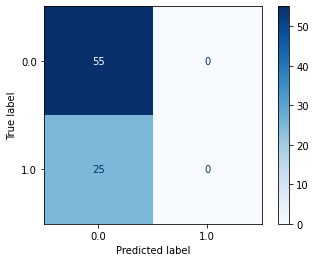

In [110]:
plot_confusion_matrix(svc_clf_dataset_two, x_test_vec_dataset_two, y_test, cmap=plt.cm.Blues);

Мы получаем достаточное плохое качество классификации, как и в предыдущем эксперименте с первым датасетом. Аналогично, мы не получаем ложно позитивных срабатывание, зато получаем много (25) ложно негативных. Посмотрим на некоторые из них.

Ложно негативное срабатывание:

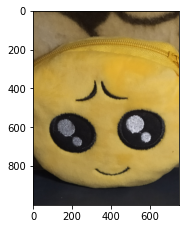

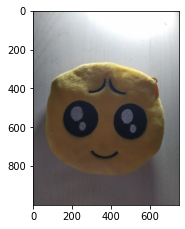

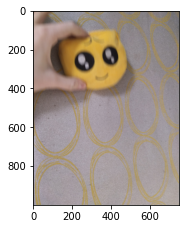

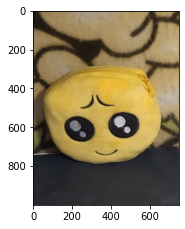

In [123]:
false_negative_idx = false_negative(y_test, svc_clf_pred_dataset_two)[1]
for i in range(len(false_negative_idx[:4])):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    show_image(x_test[false_negative_idx[i]])

Как видим, на втором датасете хорошо себя показали Quadratic classifier и Gaussian Process Classifier, но выступил значительно хуже Support Vector Classifier. В целом результаты классфикации на втором датасете, аналогичны результату на первом.

Теперь перейдем к третью датасету. Будем классифицировать следующий объект:

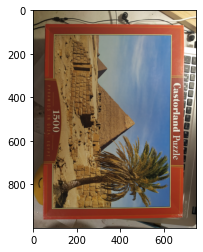

In [125]:
show_image(cv.imread('dataset3/original_picture.png'))

Фотографии с нашим объектом:

In [126]:
picture_with_object = prepare_data('dataset3/dataset3_compress', False)
print('Count picture with object:', len(picture_with_object))

Count picture with object: 115


Фотографии без нашего объекта:

In [127]:
picture_without_object = prepare_data('dataset1/dataset1_compress', False)
picture_without_object.extend(prepare_data('dataset2/dataset2_compress', False))

print('Count picture without object', len(picture_without_object))

Count picture without object 203


Собираем общий датасет (картинки с нашим объектом + картинки без нашего объекта)

In [129]:
data = picture_with_object + picture_without_object
y = np.hstack([np.ones(len(picture_with_object)), np.zeros(len(picture_without_object))])

Разбиваем на test и train

In [130]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

Теперь обучаем bag of words на train выборке для нашего датасета (используем дескриптор SIFT)

In [131]:
k_means_train_dataset_three = fit_bag_of_words(x_train, calc_SIFT)

Теперь сформируем датасеты в векторном представлении картинок, и проведем эксперименты с классификаторами Quadratic classifier и Gaussian Process Classifier. Используем дескриптор SIFT


In [132]:
x_train_vec_dataset_three = np.array([picture_to_vector(pic, k_means_train_dataset_three, calc_SIFT) 
                                    for pic in x_train])
x_test_vec_dataset_three = np.array([picture_to_vector(pic, k_means_train_dataset_three, calc_SIFT) 
                                   for pic in x_test])

Теперь обучим классификаторы Quadratic classifier, Gaussian Process Classifier и Support Vector Classifier

In [133]:
quadratic_clf_dataset_three = QuadraticDiscriminantAnalysis()
gaussian_process_clf_dataset_three = GaussianProcessClassifier(1.0 * RBF(1.0))
svc_clf_dataset_three = SVC(kernel="linear", C=0.025)

quadratic_clf_dataset_three.fit(x_train_vec_dataset_three, y_train)
gaussian_process_clf_dataset_three.fit(x_train_vec_dataset_three, y_train)
svc_clf_dataset_three.fit(x_train_vec_dataset_three, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Теперь сделаем предсказания с помощью наших классификаторов и посмотрим на результаты:

In [134]:
quadratic_clf_pred_dataset_three, quadratic_result_dataset_three = predict_probability(quadratic_clf_dataset_three, x_test_vec_dataset_three, y_test)
gaussian_process_clf_pred_dataset_three, gaussian_process_result_dataset_three = predict_probability(gaussian_process_clf_dataset_three, x_test_vec_dataset_three, y_test)
svc_clf_pred_dataset_three, svc_result_dataset_three = predict_probability(svc_clf_dataset_three, x_test_vec_dataset_three, y_test)

Посмотрим на результаты работы Quadratic classifier

In [138]:
quadratic_result_dataset_three.print_result()

Accuracy = 0.925
Mean time = 2.003312110900879e-05
False negative score = 6
False positive score = 0


Confusion matrix:

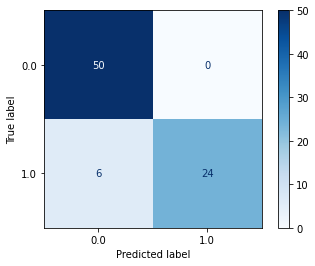

In [139]:
plot_confusion_matrix(quadratic_clf_dataset_three, x_test_vec_dataset_three, y_test, cmap=plt.cm.Blues);

Посмотрим на результаты работы Gaussian Process Classifier

In [141]:
gaussian_process_result_dataset_three.print_result()

Accuracy = 0.975
Mean time = 3.47137451171875e-05
False negative score = 1
False positive score = 1


Confusion matrix:

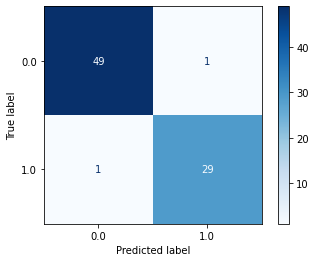

In [142]:
plot_confusion_matrix(gaussian_process_clf_dataset_three, x_test_vec_dataset_three, y_test, cmap=plt.cm.Blues);

Как и раньше, с помощью классификаторов Quadratic classifier и Gaussian Process classifier мы добиваемся стабильно высоких результатов.

Посмотрим на результаты классификатора SVC

In [143]:
svc_result_dataset_three.print_result()

Accuracy = 0.625
Mean time = 2.5254487991333007e-05
False negative score = 30
False positive score = 0


Confusion matrix:

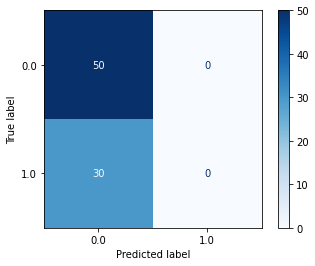

In [146]:
plot_confusion_matrix(svc_clf_dataset_three, x_test_vec_dataset_three, y_test, cmap=plt.cm.Blues);

Аналогично, с помощью классификатора SVC мы получаем не очень хорошое качество.

***Теперь рассмотрим картину в целом***

Посмотрим на результаты работы классификатора Quadratic classifier на всех трех датасетах.

In [152]:
quadratic_result.print_result()

Accuracy = 0.95
Mean time = 1.7309188842773436e-05
False negative score = 4
False positive score = 0


In [153]:
quadratic_result_dataset_two.print_result()

Accuracy = 0.975
Mean time = 2.397000789642334e-05
False negative score = 1
False positive score = 1


In [155]:
quadratic_result_dataset_three.print_result()

Accuracy = 0.925
Mean time = 2.003312110900879e-05
False negative score = 6
False positive score = 0


In [160]:
def draw_plot_accuracy_dataset(accuracy, num_dataset):
    plt.plot(num_dataset, accuracy, c='red')
    plt.xlabel("Dataset number")
    plt.ylabel("Accuracy")
    plt.xticks(num_dataset)
    plt.title("Accuracy of dataset")
    plt.show()

In [164]:
def draw_plot_mean_time_dataset(mean_time, num_dataset):
    plt.plot(num_dataset, mean_time, c='red')
    plt.xlabel("Dataset number")
    plt.ylabel("Mean time")
    plt.xticks(num_dataset)
    plt.title("Mean time predict of dataset")
    plt.show()

Построим график зависимости точности от датасета:

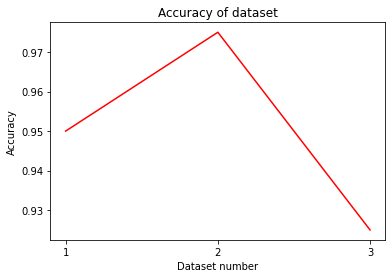

In [165]:
draw_plot_accuracy_dataset([quadratic_result.accuracy, quadratic_result_dataset_two.accuracy,
                            quadratic_result_dataset_three.accuracy], [1, 2, 3])

Построим график зависимости среднего времени предсказания объекта от датасета:

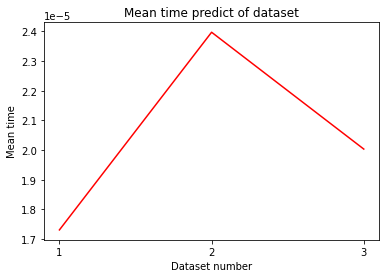

In [166]:
draw_plot_mean_time_dataset([quadratic_result.mean_time, quadratic_result_dataset_two.mean_time,
                            quadratic_result_dataset_three.mean_time], [1, 2, 3])

Можно сделать выводы, что на всех трех датасетах Quadratic classifier позволяет достичь высокого качества классификации (как мы уже замечали, вследствие сбалансированности классов, точность является хорошой метрикой качества бинарной классификации). Среднее время предсказания одного объекта является очень малым (около 2e-5), потому что объекты уже представляют собой векторные представления картинок, и основное время тратиться на обучение bag of words на обучающей выборке, и перевод новых картинок в векторное представление.

Посмотрим на результаты работы классификатора Gaussian process classifier на всех трех датасетах.

In [169]:
gaussian_process_result.print_result()

Accuracy = 0.9875
Mean time = 3.299415111541748e-05
False negative score = 1
False positive score = 0


In [170]:
gaussian_process_result_dataset_two.print_result()

Accuracy = 0.95
Mean time = 3.953278064727783e-05
False negative score = 3
False positive score = 1


In [171]:
gaussian_process_result_dataset_three.print_result()

Accuracy = 0.975
Mean time = 3.47137451171875e-05
False negative score = 1
False positive score = 1


Построим график зависимости точности от датасета:

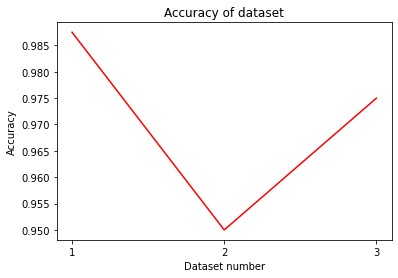

In [173]:
draw_plot_accuracy_dataset([gaussian_process_result.accuracy, gaussian_process_result_dataset_two.accuracy,
                            gaussian_process_result_dataset_three.accuracy], [1, 2, 3])

Построим график зависимости среднего времени предсказания объекта от датасета:

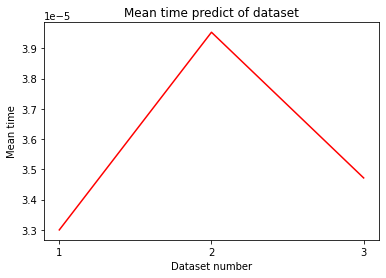

In [174]:
draw_plot_mean_time_dataset([gaussian_process_result.mean_time, gaussian_process_result_dataset_two.mean_time,
                            gaussian_process_result_dataset_three.mean_time], [1, 2, 3])

Как видим выше, Gaussian Process classifier позволяет достичь результаты аналогичные Quadratic classifier.

Теперь рассмотрим последний классификатор - Support Vector Classifier

In [175]:
svc_result.print_result()

Accuracy = 0.6625
Mean time = 2.0810961723327635e-05
False negative score = 27
False positive score = 0


In [176]:
svc_result_dataset_two.print_result()

Accuracy = 0.6875
Mean time = 2.1478533744812013e-05
False negative score = 25
False positive score = 0


In [177]:
svc_result.print_result()

Accuracy = 0.6625
Mean time = 2.0810961723327635e-05
False negative score = 27
False positive score = 0


Построим график зависимости точности от датасета:

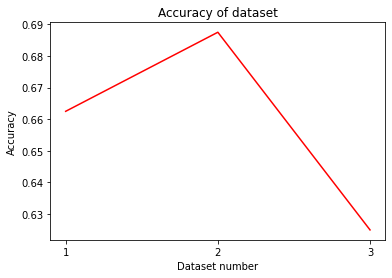

In [178]:
draw_plot_accuracy_dataset([svc_result.accuracy, svc_result_dataset_two.accuracy,
                            svc_result_dataset_three.accuracy], [1, 2, 3])

Построим график зависимости среднего времени предсказания объекта от датасета:

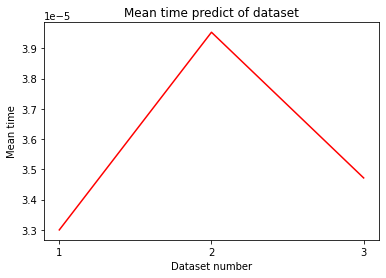

In [180]:
draw_plot_mean_time_dataset([gaussian_process_result.mean_time, gaussian_process_result_dataset_two.mean_time,
                            gaussian_process_result_dataset_three.mean_time], [1, 2, 3])

Как видим с результатов выше, Support Vector Classifier в среднем позволяется достичь достаточно низких результатов классификации, время выполнения все так же остается достаточно быстрым.

***Общий вывод*** можно сделать такой (неочевидный), что в первую очередь на классификацию будет влиять качество признаков, или иначе говоря полученное векторное представление нашей картинки, имея на руках хорошое отображения из пространства картинок в пространство вектором, мы дальше можем позволить решать себе задачу классификации любыми доступными нам методами. Очевидно, решать задачу классификации проще и люди давно научились делать это хорошо, чем строить признаковые описание картинок. Из наших экспериментом мы пришли к выводу, что с задачей классификации картинки, при фиксированном векторном описании лучше всего справляются классификаторы - Quadratic и Gaussian Process.

Теперь перейдем к части, где мы будем пытаться обнаружить наш предмет на видео.

Сначала напишем техническую функцию-генератор, которая будет обходить матрицу (изображение) скользящим окном заднного размера.

In [185]:
def correct_slice(current_x, current_y, x_size, y_size, matrix_shape):
    return (current_x + x_size - 1 < matrix_shape[0]) and (current_y + y_size - 1 < matrix_shape[1])

def sliding_window(mtx, x_size, y_size, dx_step, dy_step):
    current_x, current_y = (0, 0)
    while True:
        if not correct_slice(current_x, current_y, x_size, y_size, mtx.shape):
            break
        
        yield current_x, current_y, mtx[current_x: current_x + x_size, current_y: current_y + y_size]
        
        if current_x + dx_step  < mtx.shape[0] and correct_slice(current_x + dx_step, current_y, x_size, y_size, mtx.shape):
            current_x += dx_step
        elif current_y + dy_step < mtx.shape[1] and correct_slice(current_x, current_y + dy_step, x_size, y_size, mtx.shape):
            current_x = 0
            current_y += dy_step
        else:
            break

In [186]:
def gauss_filter(img):
    return cv.GaussianBlur(img, (5,5), 0).clip(0, 255).astype(np.uint8)

Опишем процесс детекции предмета на видео. Очевидно, видео разбивается на кадры и детекцию проводим в пределах каждого кадра. Кадр мы обходим скользящим окном, и на скользящее окно смотрим как на новое изображение на котором мы и будем искать банку рево. Используя ранее обученный bag of words переводим это изображение (скользящее окно) в векторное представление и с помощью ранее обученного классификатора предсказываем принадлежность нашому классу. И среди всех таких скользящих окном выбираем то, где принадлежность к нашему классу максимальная, и по контурам этого окна рисуем прямоугольник, таким образом получаем детекцию предмета на видео.

In [206]:
def process_video(input_filename, output_filename, bag_of_words, pretrain_clf, threshold=0.5):
    cap = cv.VideoCapture(input_filename)
    full_hd_shape = (1920, 1080)
    vid = cv.VideoWriter(output_filename, cv.VideoWriter_fourcc(*'mp4v'), 24, full_hd_shape, True)

    sliding_window_sizes = [(250, 800), (800, 250)]
    step_dx = full_hd_shape[1] // 5
    step_dy = full_hd_shape[0] // 5

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            best_proba = 0
            best_curr_x, best_curr_y = None, None
            best_sl_size = None, None
            frame = gauss_filter(frame)
            for sliding_window_size in sliding_window_sizes:
                for curr_x, curr_y, subwindow in sliding_window(frame, *sliding_window_size, step_dx, step_dy):
                    try:
                        subwindow_vector_representation = picture_to_vector(subwindow, bag_of_words, calc_SIFT)
                        pred_proba = pretrain_clf.predict_proba([subwindow_vector_representation])[0][1]
                        if pred_proba > threshold:
                            if pred_proba > best_proba:
                                best_proba = pred_proba
                                best_curr_x, best_curr_y = curr_x, curr_y
                                best_sl_size = sliding_window_size
                    except:
                        print("incorrect frame")

            if best_proba > 0:
                cv.rectangle(frame, 
                             (best_curr_y, best_curr_x), 
                             (best_curr_y + best_sl_size[1], best_curr_x + best_sl_size[0]), 
                             (255, 0, 0), 5) 

            vid.write(frame)
        else:
            break

    vid.release()
    cap.release()
    cv.destroyAllWindows()

In [207]:
input_names = ['video_test.mp4', 'video2.mp4', 'video3.mp4']
output_names = ['out1.mp4', 'out2.mp4', 'out3.mp4']
list_bag_of_words = [k_means_train_sift, k_means_train_dataset_two, k_means_train_dataset_three]
list_of_pretrained_classifier = [gaussian_process_clf, gaussian_process_clf_dataset_two, gaussian_process_clf_dataset_three]

In [ ]:
count_video = 3
threshold = 0.65

for i in range(count_video):
    process_video(input_names[i], output_names[i], list_bag_of_words[i], list_of_pretrained_classifier[i], threshold)

incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrec

Общий вывод можно сделать такой, что классификация предметов на видео, принципиально ничем не отличается от классификации предметов на изображениях, но стоить заметить, что видео обычно имеет более маленькое расширение, чем изображении, и это нужно учитывать при обучении классификаторов. Так же при потоком стриминге важна скорость обработки изображения, но тут как мы уже заметили выше, основные ресурсы уходят на то, что бы получить векторное представление кадра, классификаторы относительно этого работают быстро и очень быстрою.

Запись уже обработанного видео, так как и датасет с картинка можно найти тут:

https://drive.google.com/drive/folders/1U8o1edLtNn6z-ix0pugcpDMRbQejrpMi?usp=sharing